# Notebook to reproduce the main results of 2501.07631

## Standard import and definitions, plus some useful function definitions

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import json
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import matplotlib.pylab as pylab
from scipy.optimize import curve_fit
from scipy import integrate
import csv
from os import system
from pathlib import Path

colors = ['#8a1f1f','#79a43a','#C59D34','#171782', '#cf6717','#ad6faa',
          '#009999','#828282']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 2.

from plot_params import params
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['legend.edgecolor'] = 'black'

# Constants in SI
eV2Joule = 1.6021*10**(-19)
hbar = 6.62 * 10**(-34) / (2* np.pi)
pc2meter = 3.086 * 10**(16)
arcsec2rad = 4.84814 * 10**(-6)
clight = 3*10**8
G_const = 6.67 * 10**(-11)
m_sun = 1.989 * 10**(30)
yr2sec = 365.25 * 24 *3600
eV2kg = eV2Joule/clight**2
# Other constants
hbar_eV = 4.135667696e-15 / (2*np.pi) # In eV*sec
M_planck = 1.22e19 # in GeV
G_astro = G_const/clight**2*m_sun/1e3/pc2meter # G_Newton in kpc/Msun


# Cosmology
h0 = 0.674
Om = 0.122/h0**2
Ob = 0.022/h0**2
OL = 1 - Om - Ob
H_0 = h0*100

def rewrite_last(n=1): # rewrites the last character, to make sure the array is properly "closed"
    txt = Path('data_plot.txt').read_text()
    txt = txt[:-n] + ']'
    f = open('data_plot.txt', 'w')
    f.write(txt)
    f.close()

# Converting in grid units
def phy2grid_units(mass, L, Lphys):
    # beta is the rescaling parameter (or v**2 for Levkov), mass in electronvolt
    beta = ((hbar_eV*clight/1e3/pc2meter)/ mass*L/Lphys)**2
    t_unit = beta * mass/hbar_eV*1e9*yr2sec  # to what 1Gyrs corresponds in grid unit
    x_unit = np.sqrt(beta) * mass/(hbar_eV*clight)*1e3*pc2meter # to what 1 kpc corresponds in grid unit
    mass_unit = 4*np.pi*G_astro/np.sqrt(beta) * (mass/hbar_eV/clight*1e3*pc2meter) # to what 1 Msun corresponds in grid unit
    density_unit = mass_unit/x_unit**3 # to what 1 M_sun/kpc^3 corresponds in grid unit 
    return x_unit, density_unit, t_unit

# Find a specific value in an array
def find_value(value, array):
  result = len(array)-1
  for i in range(len(array)):
    if array[i] > value:
      result = i-1
      break
  return result

def periodic(x, L):
  return np.where(np.abs(x) > L/2, x-np.sign(x)*L, x)

/tmp/ipykernel_272852/3334702666.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


## Choose the specific simulation

In [ ]:
runs_info_arr = []

# Index 0, NFW, Fornax, m=1e-21, L=12 kpc
runs_info_arr.append(["out_stars/halo_stars_NFW_nfields_1_Nx256_L_100.000000_rs_12.500000_rhos_0.050000_r_plummer_2.000000_M_plummer_1.000000_num_stars_10000_profiles.txt",
                      "Fornax_1em21_smallrPlum",1e-21,12])
# # Index 1, Burkert, Fornax, m=1e-22, L=40kpc, beta=0
# runs_info_arr.append(["out_stars/halo_stars_anisotropy_Burkert_nfields_1_Nx256_L_100.000000_rs_3.750000_rhos_0.020000_r_plummer_0.500000_M_plummer_1.000000_beta_0.000000_num_stars_10000_profiles.txt",
#                       "Fornax_1em22_Burkert",1e-22,40])
# # Index 2, NFW, m=5e-21, Leo II, L= 5 kpc,
# runs_info_arr.append(["out_stars/halo_stars_anisotropy_NFW_nfields_1_Nx256_L_100.000000_rs_14.000000_rhos_0.042000_r_plummer_0.500000_M_plummer_1.000000_beta_-0.300000_num_stars_10000_profiles.txt",
#                       "LeoII_5em21",5e-21,5])
# Index of the run, change to plot other runs results
ind_run = 0

time_sigma_compute =10 # in Gyr, when you compute \sigma_los
# Wheter to use beta anisotropy in Jeans analysis
flag_use_beta = True
# Use physical units as specified in runs_info_arr array
phys_units = True
file_name, savefig_name, m_particle, Lphys_run = runs_info_arr[ind_run]
print("Run:", savefig_name, file_name)


Run: Fornax_1em21_smallrPlum out_stars/halo_stars_NFW_nfields_1_Nx256_L_100.000000_rs_12.500000_rhos_0.050000_r_plummer_2.000000_M_plummer_1.000000_num_stars_10000_profiles.txt


## Upload simulation data

In [4]:
system("bash change_grid.sh "+file_name)
rewrite_last()
f = open('data_plot.txt')
array = np.array(json.load(f))
f.close()

file_data = file_name.replace('profiles.txt','times_grid.txt')
system("bash change_grid.sh "+file_data)
rewrite_last()
f = open('data_plot.txt')
array_grid = np.array(json.load(f))
times_grid = array_grid[:,0]
f.close()

file_data = file_name.replace('profiles.txt','times_profile.txt')
system("bash change_grid.sh "+file_data)
rewrite_last()
f = open('data_plot.txt')
array_data = np.array(json.load(f))
time_array = range(len(array_data))
f.close()

times_sim = np.array(array_data[:,0])
max_density = np.array(array_data[:,1])
maxx = np.array(array_data[:,2])
maxy = np.array(array_data[:,3])
maxz = np.array(array_data[:,4])
e_kin_total = np.array(array_data[:,5])
e_pot_time = np.array(array_data[:,6])
mass_total = np.array(array_data[:,7])
etot = np.array(array_data[:,8])

f = open(file_name.replace('profiles.txt','initial_cond_info.txt'))
try:
    initial_cond_arr = np.loadtxt(f,dtype=str)
except: # In certain cases, the initial condition array has different number of columns for different rows
    initial_cond_array = np.loadtxt(f,dtype=str, max_rows=1)
Rs_run, rhos_run = float(initial_cond_arr[2]), float(initial_cond_arr[4])
label_profile= initial_cond_arr[0]

flag_stars_averages = True
try:
  file_data = file_name.replace('profiles.txt','times_profile_stars.txt')
  system("bash change_grid.sh "+file_data)
  rewrite_last()
  f = open('data_plot.txt')
  array_data_stars = np.array(json.load(f))
  f.close()
  times_sim_stars = np.array(array_data_stars[:,0])
  center_mass_stars_from_file = np.array(array_data_stars[:,1:4])

  file_data = file_name.replace('profiles.txt','profile_stars.txt')
  system("bash change_grid.sh "+file_data)
  rewrite_last()
  f = open('data_plot.txt')
  array_stars_profile = np.array(json.load(f))
  f.close()
  distance_from_center_stars = array_stars_profile[:,0,0]
  density_uldm_from_center_stars = array_stars_profile[:,0,1]
  energy_kin_stars = array_stars_profile[:,0,2]
  energy_pot_stars = array_stars_profile[:,0,3]
  Phi_sim_stars = array_stars_profile[:,0,4]
except:
  flag_stars_averages = False
  print("No profile data from center of stars")

file_data = file_name.replace('profiles.txt','runinfo.txt')
system("bash change_grid.sh "+file_data)
f = open('data_plot.txt')
array_runinfo = np.array(np.loadtxt(f))
f.close()

Length = array_runinfo[2]
time_final = array_runinfo[0]
Nx = array_runinfo[4]
delta_x = Length/Nx

def distance(i, whichfield): # distance at the (discretized) time i, middle point of the bin;
    # this means that, when integrate up to distance(i), you actually integrate up to distance(i) + 0.5*Length/Nx
    return array[i][whichfield][0]
def density(i, whichfield): # distance at the (discretized) time i
    return array[i][whichfield][1]
def energy_kin(i, whichfield): # distance at the (discretized) time i
    return array[i][whichfield][2]
def energy_pot(i, whichfield): # distance at the (discretized) time i
    return array[i][whichfield][3]
def Phi_sim(i, whichfield): # distance at the (discretized) time i
    return array[i][whichfield][4]

if phys_units==True: # multiply by the physical quantities to get the tilde ones
  x_unit, density_unit, t_unit = phy2grid_units(m_particle, Length, Lphys_run)
  print("t_unit", t_unit, "x_unit", x_unit, "density_unit", density_unit)
else:
  # If physical units are not available, use the grid units
  print("Physical units not available")
  x_unit, density_unit, t_unit = 1,1,1
mass_unit = density_unit*x_unit**3
vel_unit = x_unit/t_unit*1e9*yr2sec/(pc2meter) # in km/s
print('vel unit', vel_unit)

t_unit 136.31947605687222 x_unit 8.333333333333332 density_unit 3.040008749895102e-09
vel unit 0.06251279126934382


## ULDM profiles and soliton-halo relation

cut index, time_compute 4 70
rcore, rcore actual expected 0.09389916532729994 0.08691959824500056


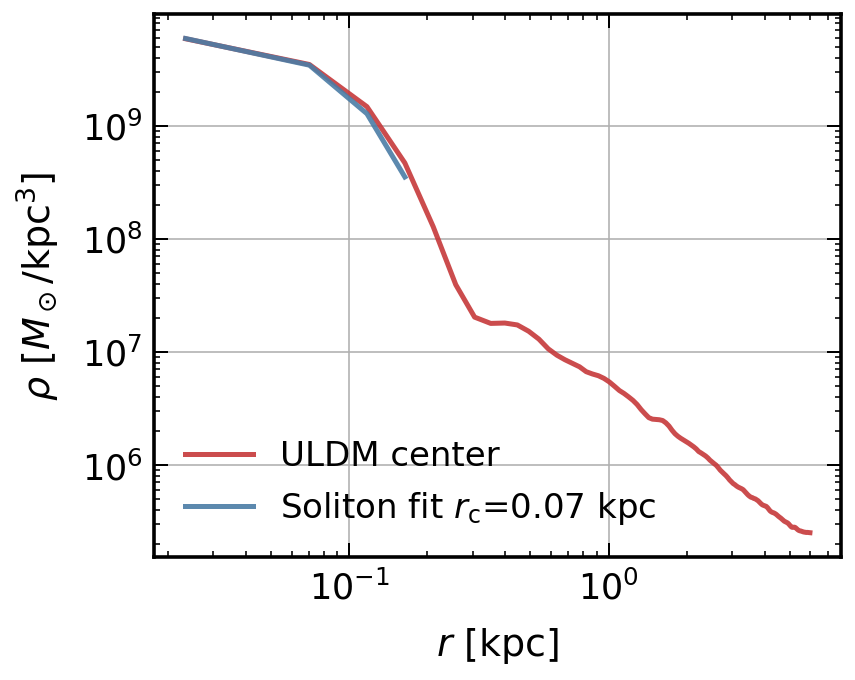

time 10.10543790107645
Mc, Mc_infty 13.083393086175793 54.45901835163832
Mtot, Ekin tot 661678284.9948736 952.089
rc soliton 0.07492884620745308


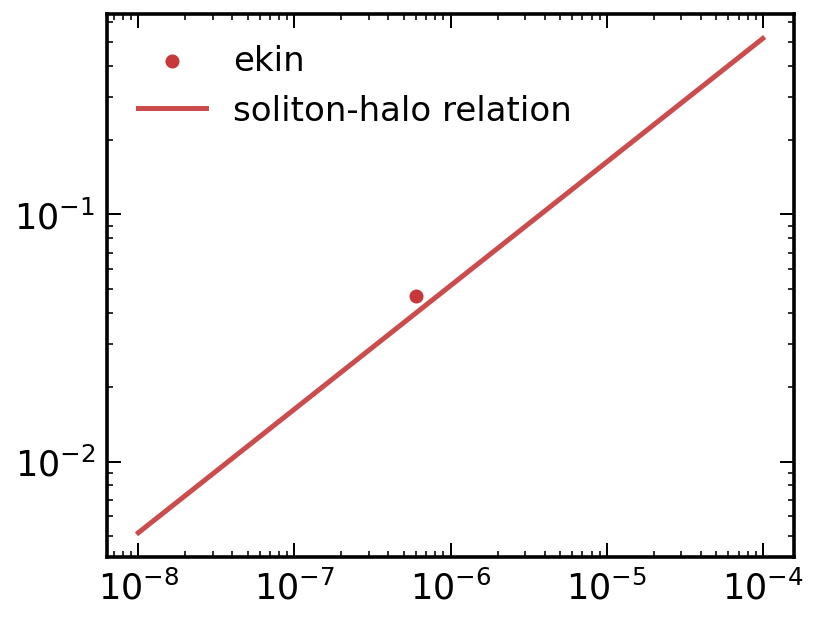

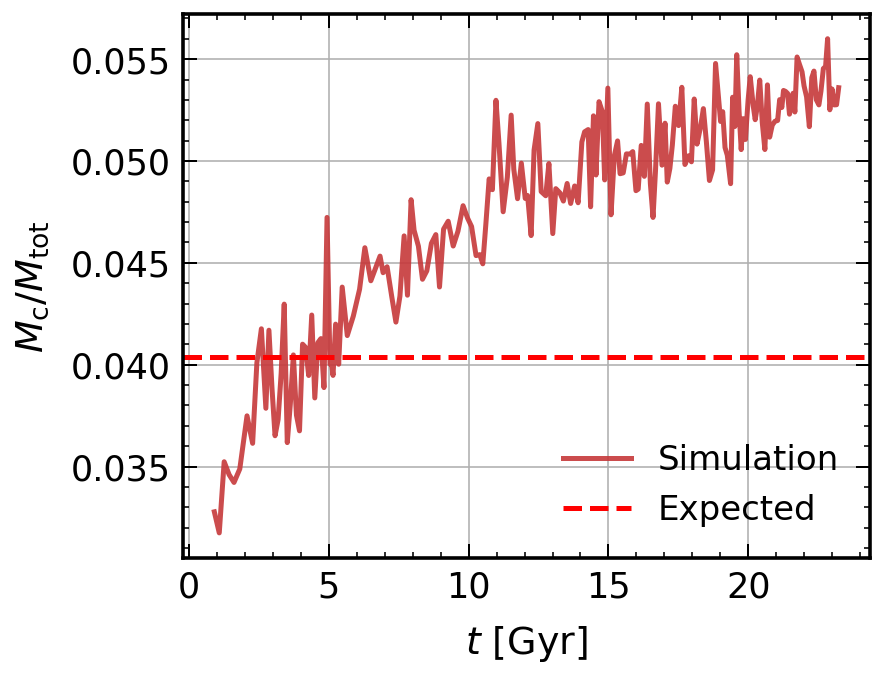

In [10]:
from scipy.integrate import quad
def potential_nfw(r, rs, rhos):
  # Dimensionless units
  return -rhos*rs**3/r*np.log(1+r/rs)
def Ep_nfw(r, rs, rhos):
  result, _ = quad(lambda x: 0.5*4*np.pi*x**2*potential_nfw(x, rs, rhos)*density_nfw(x,rs,rhos), 0, r)
  return result

def mass_Burkert(rmax, Rs, Rhos):
    x = rmax / Rs
    return np.pi * Rhos * Rs**3 * (np.log((x*x + 1) * (x + 1)**2) - 2 * np.arctan(x))
def potential_Burk(r, Rs, Rhos):
    xr = r / Rs
    result = -1./4 * Rhos * Rs**2 * (np.pi - 2 * np.arctan(xr) + np.log((xr + 1)**2 / (xr**2 + 1)))
    return result - mass_Burkert(r, Rs, Rhos) / (4 * np.pi * r)
def Ep_Burkert(r, Rs, Rhos):
  result, _ = quad(lambda x: 0.5*4*np.pi*x**2*potential_Burk(x, Rs, Rhos)*density_burkert(x,Rs,Rhos), 0, r)
  return result
def density_nfw(r, rs, rhos):
  return rhos*rs**3/((r+rs)**2*r)
def mass_nfw(r, rs, rhos):
  return 4*np.pi*rhos*rs**3*(np.log(1+r/rs) - r/(r+rs))
def density_burkert(r, r0, rho0):
  return rho0 /((1+r/r0)*(1+(r/r0)**2))
def mass_burkert(r, r0, rho0):
  x = r/r0
  return np.pi * rho0 * r0**3 * (np.log((x*x + 1) * (x + 1)**2) - 2 * np.arctan(x))

if label_profile == "NFW": 
  mcore_expected = 4.1*4*np.pi*np.sqrt(-Ep_nfw(Length/2, Rs_run, rhos_run)/2/mass_nfw(Length, Rs_run, rhos_run))
elif label_profile == "Burkert":
  mcore_expected = 4.1*4*np.pi*np.sqrt(-Ep_Burkert(Length/2, Rs_run, rhos_run)/2/mass_Burkert(Length, Rs_run, rhos_run))
rcore_relation = 1.31*26/mcore_expected
rcore_phys_expected = rcore_relation/x_unit

a = 0.228
b = 4.071
time_compute = np.min([find_value(time_sigma_compute,times_sim/t_unit)+1, len(times_sim)-1])
factor_half = 2**(1.0/(2*b)) -1
def soliton_fit(r, r_c):
  if r_c == 0:
    return 0
  else:
    lambda2 = factor_half/(a*a*r_c*r_c)
    rho_sol = (lambda2 / (1 + factor_half*(r/r_c)**2)**b)**2
    return rho_sol
def r_c_max_density(max_density):
    return np.sqrt(factor_half)/(a*max_density**(1./4))
def integrand_sol(r, r_c):
    return 4*np.pi * r**2 * soliton_fit(r, r_c)
def mass_soliton(r_c_sol,inf): # If inf==True, integrate until np.inf
    if inf == True:
        return integrate.quad(integrand_sol, 0, np.inf, args=(r_c_sol,))[0]
    elif inf == False:
        return integrate.quad(integrand_sol, 0, r_c_sol, args=(r_c_sol,))[0]
r_c_guess = r_c_max_density(max_density[time_compute])
cut_index = np.maximum(int(r_c_guess/delta_x)*4,3)
print("cut index, time_compute", cut_index, time_compute)
params_sol, params_cov_sol = curve_fit(soliton_fit, distance(0,0)[:cut_index], density(time_compute,0)[:cut_index], bounds=(0.1*r_c_guess, 8*r_c_guess))

mcore_actual_expected = 4.1*(4*np.pi)*np.sqrt((e_kin_total[-1])/mass_total[0])
rcore_phys_actual_expected = 1.31*26/mcore_actual_expected/x_unit
print('rcore, rcore actual expected', rcore_phys_expected, rcore_phys_actual_expected)

plt.loglog(distance(time_compute,0)/x_unit, density(time_compute,0)/density_unit, label='ULDM center')
plt.loglog(distance(time_compute,0)[:cut_index]/x_unit, soliton_fit(distance(time_compute,0)[:cut_index], params_sol[0])/density_unit, 
           label='Soliton fit '+ r'$r_{\rm c}$='+str(params_sol[0]/x_unit)[:4]+' kpc'
           )
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\rho$ [$M_\odot/$kpc$^3$]')
plt.grid()
plt.legend()
plt.show()

e_kin_time = e_kin_total[time_compute] 
rel_range = np.logspace(-8,-4,20)
r_c_sol_time = params_sol[0]

mass_core_rcfit_time = integrate.quad(integrand_sol, 0, r_c_sol_time, args=(r_c_sol_time,))[0]
mass_core_infty_time = integrate.quad(integrand_sol, 0, np.inf, args=(r_c_sol_time,))[0]

print('time', times_sim[time_compute]/t_unit)
print('Mc, Mc_infty', mass_core_rcfit_time, mass_core_infty_time)
print('Mtot, Ekin tot', mass_total[time_compute]/mass_unit, e_kin_time)
print('rc soliton', r_c_sol_time/x_unit)
plt.scatter((e_kin_time)/mass_total[time_compute]**3, mass_core_infty_time/mass_total[time_compute], label='ekin')
plt.legend()
plt.loglog(rel_range, 4.1*(4*np.pi)*np.sqrt(rel_range), label='soliton-halo relation')
plt.legend()
plt.show()


Mc_arr_here = []
start_index_rc_arr = 5
for i in range(start_index_rc_arr,len(times_sim)):
  r_c_guess = r_c_max_density(max_density[i])
  cut_index = np.maximum(int(r_c_guess/delta_x)*4,3)
  params_sol, params_cov_sol = curve_fit(soliton_fit, distance(0,0)[:cut_index], density(i,0)[:cut_index], bounds=(0.1*r_c_guess, 8*r_c_guess))
  if i ==start_index_rc_arr:
    rc_first = params_sol
    cut_index_first = cut_index
  Mc_arr_here.append(integrate.quad(integrand_sol, 0, np.inf, args=(params_sol,))[0])
Mc_arr_here = np.array(Mc_arr_here)
plt.plot(times_sim[start_index_rc_arr:]/t_unit, Mc_arr_here/mass_total[0], label=r'Simulation')
plt.xlabel(r'$t$ [Gyr]')
plt.ylabel(r'$M_{\rm c}/M_{\rm tot}$')
plt.axhline(y=mcore_actual_expected/mass_total[0], color='r', linestyle='--', label='Expected')
plt.grid()
plt.legend()
plt.show()

## Functions for Jeans analysis and load dwarf galaxy kinematics data

In [17]:
# Jeans modelling
from scipy.integrate import quad
import pandas as pd

# Check distribution of stars
def plummer_density(r, a, M0):
  return 3*M0/(4*np.pi*a**3) * (1+(r/a)**2)**(-5./2)
def plummer_column_density(r, a, M0):
  return M0*a**2 /np.pi* (a**2+r**2)**(-2)

def rot_vel_nfw(r, rs, rhos):
  return np.sqrt(G_astro*mass_nfw(r, rs, rhos)/r/3)*clight/1e3
# Define the velocity dispersion function sigma^2_r(r)
def rho_sigma2_r(r, density_func, mass_func, beta, max_point=np.inf, const_beta=True):
    # I consider beta to be constant, and compute it from the radial bin
    # Integrate from r to max_point, max_point should be where the density is zero
    if const_beta == True:
      integrand = lambda r: G_astro * mass_func(r) * density_func(r)* r**(2*beta(0)-2)
      integral, _ = quad(integrand, r, max_point)
      # Compute sigma^2(r)
      return integral /r**(2*beta(0)) * (clight/1e3)**2
    else:
      exp_factor = lambda s: quad(lambda x: beta(x)/x, r, s)[0]
      integrand = lambda s: G_astro * mass_func(s) * density_func(s)* s**(-2)*np.exp(2*exp_factor(s))
      integral, _ = quad(integrand, r, max_point)
      # Compute sigma^2(r)
      return integral * (clight/1e3)**2
def sigma2_los(r, beta, density_func, mass_func, column_density_func, 
               max_point_r=np.inf, max_point_los=np.inf, const_beta=True):
    ## New method, with Q^2 = x^2 - r^2
    integrand = (lambda x: rho_sigma2_r(np.sqrt(x**2+r**2), density_func, mass_func,beta, 
                                        max_point_r, const_beta)
                  * (1-beta(np.sqrt(x**2+r**2)) * r**2/(x**2+r**2)))
    # Integrate from 0 to max_point, max_point should be sqrt(L^2_*-r^2) 
    # where L_* is where stars density drops to zero
    integral, _ = quad(integrand, 0, max_point_los)
    # Compute sigma^2(r)
    return 2*integral / column_density_func(r) 

# Random line of sight
def random_los():
  theta_los, phi_los = np.random.uniform(0,np.pi), np.random.uniform(0,2*np.pi)
  los = np.array([np.sin(theta_los)*np.cos(phi_los), np.sin(theta_los)*np.sin(phi_los), np.cos(theta_los)])
  # Choose an arbitrary vector that is not parallel to los
  arbitrary_vector = np.array([1, 0, 0]) if los[0] == 0 else np.array([0, 1, 0])
  # First perpendicular vector using cross product
  perpendicular1 = np.cross(los, arbitrary_vector)
  perpendicular1 /= np.linalg.norm(perpendicular1)  # Normalize to get unit vector
  # Second perpendicular vector using cross product
  perpendicular2 = np.cross(los, perpendicular1)
  perpendicular2 /= np.linalg.norm(perpendicular2)  # Normalize to get unit vector
  return los, perpendicular1, perpendicular2

def perp_vector(vect):
  """2 Perpendicular vectors to the input vector

  Args:
      vect: input vector

  Returns:
      _type_: 2 perpendicular vectors
  """
  arbitrary_vector = np.array([1, 0, 0]) if vect[0] == 0 else np.array([0, 1, 0])
  # First perpendicular vector using cross product
  perpendicular1 = np.cross(vect, arbitrary_vector)
  perpendicular1 /= np.linalg.norm(perpendicular1)  # Normalize to get unit vector
  # Second perpendicular vector using cross product
  perpendicular2 = np.cross(vect, perpendicular1)
  perpendicular2 /= np.linalg.norm(perpendicular2)  # Normalize to get unit vector
  return perpendicular1, perpendicular2


# M(r), the mass as a function of the radius
def mass_radius_compute(x_arr, density_arr):
  mass_radius = np.zeros(len(x_arr))
  for i in range(len(x_arr)):
    if i ==0:
      # For the first point, dx is actually just x_arr[0], take uniform sphere formula
      mass_radius[i] = 4*np.pi*x_arr[i]**3*density_arr[i]/3
    else:
      dx = x_arr[i] - x_arr[i-1]
      dy = (x_arr[i]**2 * density_arr[i] + x_arr[i - 1]**2 *density_arr[i - 1]) / 2.
      mass_radius[i] = 4*np.pi*dy*dx + mass_radius[i-1]
  return np.array(mass_radius)

def mass_column_compute(x_arr, column_density_arr):
  mass_column = np.zeros(len(x_arr))
  for i in range(len(x_arr)):
    if i ==0:
      # For the first point, dx is actually just x_arr[0], take uniform circle formula
      mass_column[i] = np.pi*x_arr[i]**2*column_density_arr[i]
    else:
      dx = x_arr[i] - x_arr[i - 1]
      dy = (x_arr[i] * column_density_arr[i] + x_arr[i - 1] * column_density_arr[i - 1]) / 2
      mass_column[i] = 2*np.pi*dy*dx + mass_column[i-1]
  return np.array(mass_column)


# Function to preprocess the file content
def preprocess_file_content(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    # Replace curly brackets with square brackets
    content = content.replace('{', '[').replace('}', ']')
    return content
# Load the preprocessed content as a numpy array
def load_custom_array(file_path):
    content = preprocess_file_content(file_path)
    array = np.array(eval(content))
    return array
  
## Data Fornax
data_fornax = pd.read_csv('data/Fornax_velocity_dispersion_NStar60_Pm095.csv')
bin_centers_fornax = data_fornax['bin_centers_kpc'].values
velocity_dispersions_fornax = data_fornax['velocity_dispersions_kms'].values
velocity_dispersions_err_fornax = data_fornax['velocity_dispersions_err_kms'].values
velocity_dispersions_err_fornax =[velocity_dispersions_err_fornax, velocity_dispersions_err_fornax]

## Data Fornax, probability membership 99
data_fornax99 = pd.read_csv('data/Fornax_velocity_dispersion_NStar60_Pm099.csv')
bin_centers_fornax99 = data_fornax99['bin_centers_kpc'].values
velocity_dispersions_fornax99 = data_fornax99['velocity_dispersions_kms'].values
velocity_dispersions_err_fornax99 = data_fornax99['velocity_dispersions_err_kms'].values
velocity_dispersions_err_fornax99 =[velocity_dispersions_err_fornax99, velocity_dispersions_err_fornax99]

## Data Carina
data_carina = pd.read_csv('data/Carina_velocity_dispersion_NStar10_Pm1.csv')
bin_centers_carina = data_carina['bin_centers_kpc'].values
velocity_dispersions_carina = data_carina['velocity_dispersions_kms'].values
velocity_dispersions_err_carina = data_carina['velocity_dispersions_err_kms'].values
velocity_dispersions_err_carina =[velocity_dispersions_err_carina, velocity_dispersions_err_carina]

## Data Sculptor
data_sculptor = pd.read_csv('data/Sculptor_velocity_dispersion_NStar15_Pm1.csv')
bin_centers_sculptor = data_sculptor['bin_centers_kpc'].values
velocity_dispersions_sculptor = data_sculptor['velocity_dispersions_kms'].values
velocity_dispersions_err_sculptor = data_sculptor['velocity_dispersions_err_kms'].values
velocity_dispersions_err_sculptor =[velocity_dispersions_err_sculptor, velocity_dispersions_err_sculptor]

## Data Leo II
data_leo2 = pd.read_csv('data/velocity_dispersion_dataLeoII.csv', header=None, names=['R', 'SigmaMean', 'UpperErr', 'LowerErr'])
data_leo2['R'] = pd.to_numeric(data_leo2['R'], errors='coerce')
data_leo2['SigmaMean'] = pd.to_numeric(data_leo2['SigmaMean'], errors='coerce')
data_leo2['UpperErr'] = pd.to_numeric(data_leo2['UpperErr'], errors='coerce')
data_leo2['LowerErr'] = pd.to_numeric(data_leo2['LowerErr'], errors='coerce')
data_leo2 = data_leo2.dropna()  # Drop any rows where conversion failed
bin_centers_leo2 = data_leo2['R'].values
velocity_dispersions_leo2 = data_leo2['SigmaMean'].values
velocity_dispersions_err_leo2 = np.array([velocity_dispersions_leo2- data_leo2['LowerErr'].values, 
                                          data_leo2['UpperErr'].values- velocity_dispersions_leo2])


## Load stars data

In [ ]:
# Array of the maximum density position
max_density_location  = delta_x* np.array([[maxx[i], maxy[i],maxz[i]] 
                                           for i in range(len(maxx))])
filename_search = file_name.replace('profiles.txt','')
filename_stars = filename_search+'stars.txt'
system("bash change_grid.sh "+filename_stars)
rewrite_last()
f = open('data_plot.txt')
array_stars = np.array(json.load(f))[:]
f.close()
center_mass_stars = np.zeros((3,len(times_sim)))
Nstars = len(array_stars[0,:])
Nstar_eff =0
for ind_star in range(Nstars):
  xs, ys, zs, vxs, vys, vzs = (array_stars[:,ind_star,1]-max_density_location[:,0],
                              array_stars[:,ind_star,2]-max_density_location[:,1],
                              array_stars[:,ind_star,3]-max_density_location[:,2],
                              array_stars[:,ind_star,4],array_stars[:,ind_star,5],
                              array_stars[:,ind_star,6])
  xs, ys, zs = periodic(xs,Length)/x_unit, periodic(ys,Length)/x_unit, periodic(zs,Length)/x_unit
  rad = np.sqrt(xs**2 + ys**2 + zs**2)
  vxs, vys, vzs = vxs/vel_unit, vys/vel_unit, vzs/vel_unit
  center_mass_stars += np.array([xs, ys, zs])
  Nstar_eff+=1
center_mass_stars /= Nstar_eff


## Stellar kinematics quantities computation

shape xyz_arr (9999, 3) 9999
Max distance 33.238246254966576 (9999,) 33.333333333333336
Beta shape (30,)
params Plummer rhalf 0.23796027523498295
shape xyz_arr (8808, 3) 8808
Max distance 33.319686606134034 (8808,) 33.333333333333336
Beta shape (30,)
params Plummer rhalf -0.8134895180906806
Mask shape (30,) [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


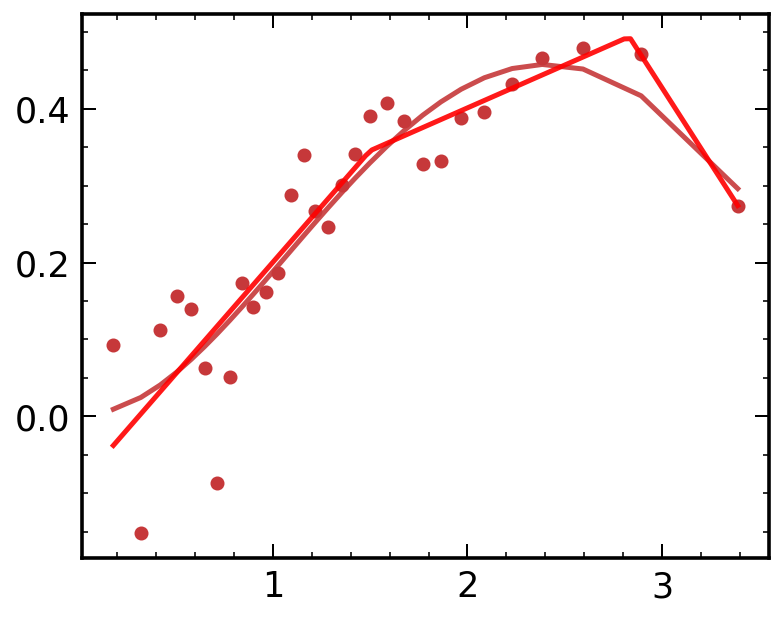

In [21]:
from matplotlib import axis
from matplotlib.pyplot import flag
from scipy.signal import savgol_filter
import pwlf

# Select stars that never cross Length_star_lim
Length_star_lim = Length/3
if Lphys_run==40:
  Length_star_lim = Length/6

def select_condition(ind_initial,ind_final):
  num=0
  ind_list = []
  for i in range(len(array_stars[0,:])):
    xyz = periodic(array_stars[ind_initial:ind_final,i,1:4]-max_density_location[ind_initial:ind_final,],Length)
    rad_xyz = np.sqrt(xyz[:,0]**2 + xyz[:,1]**2 + xyz[:,2]**2)
    if np.max(rad_xyz)<Length_star_lim:
      ind_list.append(i)
      num+=1
  return np.array(ind_list), num

# Number density of stars as a function of distance from the center
disk_flag = False

if "1em22" in savefig_name or "eoII" in savefig_name:
  nbins = 20
else:
  nbins = 30

naverages=1

# Find the index corresponding to 10 Gyrs
index_final = np.min([find_value(time_sigma_compute,times_sim/t_unit)+1, len(times_sim)-1])
index_compute= index_final-1
index0 =0

def r_half_light(time_index, n_averages=1, nbins_here=50):
  xyz_arr =[]
  index_stars, num_ = select_condition(0,time_index+1) 
  for i in index_stars:
    # Define the distance from the center of the galaxy, not the center of ULDM mass
    xyz_arr.append(periodic(array_stars[time_index,i,1:4]
                            -max_density_location[time_index,]
                            -center_mass_stars[:,time_index],Length))
  xyz_arr = np.array(xyz_arr)
  number_dist_proj = np.zeros(nbins_here)
  for _ in range(n_averages):
    los, perpendicular1, perpendicular2 = random_los()
    xyz_proj = np.array([xyz_arr[i]-np.dot(xyz_arr[i],los)*los for i in range(len(xyz_arr))])
    rad_proj = np.sqrt(xyz_proj[:,0]**2 + xyz_proj[:,1]**2+xyz_proj[:,2]**2)
    # Define radial bins based on quantiles
    bin_edges = np.quantile(rad_proj, np.linspace(0, 1, nbins_here + 1))
    for i in range(len(rad_proj)):
      index_point = np.searchsorted(bin_edges, rad_proj[i], side='right') - 1
      if index_point < nbins_here:
          number_dist_proj[index_point] += 1 / (np.pi * (bin_edges[index_point + 1]**2 - bin_edges[index_point]**2))
  number_dist_proj /= n_averages
  # Issue here when n_averaes is not 1
  dist_plot = (bin_edges[:-1] + bin_edges[1:]) / 2
  # Order rad_proj and extract the half point
  rad_proj_sorted = np.sort(rad_proj)
  r_half = rad_proj_sorted[len(rad_proj_sorted) // 2]/x_unit
  print("Number of stars considered at time", times_sim[time_index]/t_unit, num_, "r_half", r_half)
  rplum = 0 
  return r_half, rplum

def sigma2_v_measured(time_index, n_averages=1):
  xyz_arr =[] 
  index_stars, num_ = select_condition(0,time_index+1) 
  for i in index_stars:
    if time_index==0:
      xyz_arr.append(periodic(array_stars[time_index,i,1:4]
                              -center_mass_stars_from_file[time_index]
                              ,Length))
    else:
      # Define the distance from the center of the galaxy, not the center of ULDM mass
      xyz_arr.append(periodic(array_stars[time_index,i,1:4]
                              -max_density_location[time_index,]
                              -center_mass_stars[:,time_index],Length))
  xyz_arr = np.array(xyz_arr)
  print("shape xyz_arr", xyz_arr.shape, num_)
  rad = np.sqrt(xyz_arr[:,0]**2 + xyz_arr[:,1]**2 + xyz_arr[:,2]**2)
  # Define radial bins based on quantiles
  bin_edges = np.quantile(rad, np.linspace(0, 1, nbins + 1))
  bin_edges[-1] += 1e-10 #Avoid np.searchsorted error when a point is exactly the last bin edge
  
  dist_plot = np.zeros(nbins)
  for i in range(nbins):
      indices = np.where((rad >= bin_edges[i]) & (rad < bin_edges[i + 1]))[0]
      if len(indices) > 0:
          dist_plot[i] = np.mean(rad[indices])
      else:
          dist_plot[i] = (bin_edges[i] + bin_edges[i + 1]) / 2
  
  print('Max distance',np.max(rad), rad.shape, Length_star_lim)
  # dr = np.max(rad+1e-10)/nbins
  number_sigma_los = np.zeros(nbins) # number of radial bin points for velocity dispersion
  number_sigma_r = np.zeros(nbins) # number of radial bin points for velocity dispersion
  number_sigma_theta = np.zeros(nbins)
  number_sigma_phi = np.zeros(nbins)
  
  counts = np.zeros(nbins) # number of stars in each bin
  counts_proj = np.zeros(nbins) # number of stars in each bin
  number_dist = np.zeros(nbins) # number of radial bin points
  number_dist_proj = np.zeros(nbins)
  # Array to store the velocity components for each radial bin
  vr_arr = [[] for _ in range(nbins)]
  vtheta_arr = [[] for _ in range(nbins)]
  vphi_arr = [[] for _ in range(nbins)]
  for i in range(len(rad)):
    index_point = np.searchsorted(bin_edges, rad[i], side='right') - 1
    number_dist[index_point] += 1/(4*np.pi/3*(bin_edges[index_point+1]**3 - bin_edges[index_point]**3))
    vel_vect = np.array([array_stars[time_index,index_stars[i],4],array_stars[time_index,index_stars[i],5],array_stars[time_index,index_stars[i],6]])
    rad_versor = xyz_arr[i]/rad[i]
    perpendicular1, perpendicular2 = perp_vector(rad_versor)
    v_los = np.dot(vel_vect,rad_versor)/vel_unit
    v_theta = np.dot(vel_vect,perpendicular1)/vel_unit
    v_phi = np.dot(vel_vect,perpendicular2)/vel_unit
    vr_arr[index_point].append(v_los)
    vtheta_arr[index_point].append(v_theta)
    vphi_arr[index_point].append(v_phi) 
    counts[index_point] += 1
  number_sigma_r = np.array([np.std(vr_arr[pp]) for pp in range(nbins)])
  number_sigma_theta = np.array([np.std(vtheta_arr[pp]) for pp in range(nbins)])
  number_sigma_phi = np.array([np.std(vphi_arr[pp]) for pp in range(nbins)])
  # The projected
  for _ in range(n_averages):
    number_sigma_los_here = [[] for _ in range(nbins)]
    los, perpendicular1, perpendicular2 = random_los()
    xyz_proj = np.array([xyz_arr[i]-np.dot(xyz_arr[i],los)*los for i in range(len(xyz_arr))])
    rad_proj = np.sqrt(xyz_proj[:,0]**2 + xyz_proj[:,1]**2+xyz_proj[:,2]**2)
    
    # Calculate the bin edges using quantiles
    bin_edges = np.quantile(rad_proj, np.linspace(0, 1, nbins + 1))
    bin_edges[-1] += 1e-10 #Avoid np.searchsorted error when a point is exactly the last bin edge 
    bin_edges[0] = 0
    # Find the bin index for each star
    index_points = np.searchsorted(bin_edges, rad_proj, side='right') - 1
    # Extract velocity vectors
    vel_vects = array_stars[time_index, index_stars, 4:7]
    # Calculate line-of-sight velocities
    v_los = np.dot(vel_vects, los) / vel_unit
    # Calculate the number_dist_proj increments
    for i in range(len(rad_proj)):
      index_point = np.searchsorted(bin_edges, rad_proj[i], side='right') - 1
      # index_point = int(rad_proj[i]/dr)
      if index_point < nbins:
          number_dist_proj[index_point] += 1 / (np.pi * (bin_edges[index_point + 1]**2 - bin_edges[index_point]**2))
    # Update number_sigma_los
    for idx, v in zip(index_points, v_los):
      number_sigma_los_here[idx].append(v)
    # Update counts_proj
    np.add.at(counts_proj, index_points, 1)
    
    number_sigma_los += np.array([np.std(number_sigma_los_here[pp]) for pp in range(nbins)]) /n_averages
    # Replace zero points in number_sigma_los with np.nan
    number_sigma_los[number_sigma_los == 0] = np.nan
  
  number_dist_proj /=n_averages
  counts_proj /=n_averages
  dist_plot_proj = (bin_edges[:-1] + bin_edges[1:]) / 2
  dist_plot_proj = np.zeros(nbins)
  for i in range(nbins):
      indices = np.where((rad_proj >= bin_edges[i]) & (rad_proj < bin_edges[i + 1]))[0]
      if len(indices) > 0:
          dist_plot_proj[i] = np.mean(rad_proj[indices])
      else:
          dist_plot_proj[i] = (bin_edges[i] + bin_edges[i + 1]) / 2
  return number_sigma_los, number_sigma_r, number_sigma_theta,number_sigma_phi, number_dist_proj, number_dist, counts_proj, counts, dist_plot, dist_plot_proj



num_snapshots = 2
number_sigma_los_list = []
number_sigma_r_list = []
number_sigma_theta_list = []
number_sigma_phi_list = []
number_dist_proj_list = []
number_dist_list = []
counts_proj_list = []
counts_list = []
dist_plot_list, dist_plot_proj_list = [], []
surface_dist_proj_list, params_plum = [], []
beta, err_beta, r_half_light_proj, err_sigma = [], [], [], []
for ind_loop in np.linspace(index0,index_compute,num_snapshots):
  ind_loop=int(ind_loop)
  number_sigma_los, number_sigma_r, number_sigma_theta, number_sigma_phi, number_dist_proj, number_dist, counts_proj, counts, dist_plot, dist_plot_proj = sigma2_v_measured(ind_loop, naverages) 
  # Append results to lists
  number_sigma_los_list.append(number_sigma_los)
  number_sigma_r_list.append(number_sigma_r)
  number_sigma_theta_list.append(number_sigma_theta)
  number_sigma_phi_list.append(number_sigma_phi)
  number_dist_proj_list.append(number_dist_proj)
  number_dist_list.append(number_dist)
  counts_proj_list.append(counts_proj)
  counts_list.append(counts)
  dist_plot_list.append(dist_plot)
  dist_plot_proj_list.append(dist_plot_proj)
  beta.append( 1 - (number_sigma_theta**2 + number_sigma_phi**2)/number_sigma_r**2/2)
  print('Beta shape', beta[-1].shape)
  err_beta.append([3/2/(counts_proj[ll]-1)*np.abs(beta[-1][ll]) if counts_proj[ll]>5 else np.nan for ll in range(len(beta[-1]))])
  # number_dist_sigma0, number_dist_proj0, number_dist0, counts0_proj, counts0, dist_plot0, dist_plot_proj0 = sigma2_v_measured(index0) 
  params, cov = curve_fit(plummer_column_density, dist_plot_proj, number_dist_proj*x_unit**2, 
                          sigma=1*np.ones(len(number_dist_proj)))
  print('params Plummer rhalf',params[0]/x_unit)
  params_plum.append(params)
  # Find half mass radius of stars
  mass_radius_stars = mass_radius_compute(dist_plot/x_unit, number_dist*x_unit**3)
  rhalf_mass_index = find_value(0.5*np.max(mass_radius_stars), mass_radius_stars)
  mass_column_radius_stars = mass_column_compute(dist_plot_proj/x_unit, number_dist_proj*x_unit**2)
  rhalf_mass_index_proj = find_value(0.5*np.max(mass_column_radius_stars), mass_column_radius_stars)
  r_half_light_proj.append(dist_plot_proj[rhalf_mass_index_proj]/x_unit)


# Jeans modelling
# Function for interpolating mass, density, column density given data
def func_interp(r, x_points, y_points, pl_exp):
  # pl_exp = power law exponent for extrapolation
  if r > x_points[-1]:
    # print('Plus',r, x_points[-1], pl_exp)
    return y_points[-1] * (r/x_points[-1])**pl_exp
  elif r < x_points[0]:
    # print('Minus',r, x_points[0], pl_exp)
    return y_points[0]
  else:
    return np.interp(r,x_points, y_points)

# Create a mask to filter out high error values, only for last snapshot
err_beta_filtered = np.array(err_beta[-1])
mask = err_beta_filtered < 0.1
print('Mask shape', mask.shape, mask)
# Apply the mask to beta and err_beta arrays
beta_filtered = np.array(beta[-1])[mask]
err_beta_filtered = err_beta_filtered[mask]
dist_plot_beta_filtered = dist_plot[mask]
# Savgol filter window length
window_length = np.maximum(int(nbins/10),4)
# beta_smooth = beta_filtered 
beta_smooth = np.array(savgol_filter(beta_filtered, window_length=window_length, polyorder=3),dtype=float)
if flag_use_beta == True:
  beta_poly_fit = np.polyfit(dist_plot_beta_filtered/x_unit, beta_smooth, 4)
  my_pwlf = pwlf.PiecewiseLinFit(dist_plot_beta_filtered / x_unit, beta_smooth)
  # Specify the number of line segments
  num_segments = 3
  res = my_pwlf.fit(num_segments)
  beta_func = lambda x: np.poly1d(beta_poly_fit)(x)
  plt.scatter(dist_plot_beta_filtered/x_unit, beta_smooth)
  plt.plot(dist_plot_beta_filtered/x_unit, np.poly1d(beta_poly_fit)(dist_plot_beta_filtered/x_unit))
  x_hat = np.linspace(min(dist_plot_beta_filtered / x_unit), max(dist_plot_beta_filtered / x_unit), 100)
  y_hat = my_pwlf.predict(x_hat)
  plt.plot(x_hat, y_hat, label='Piecewise Linear Fit', color='red')
  plt.show()
else:
  beta_func = lambda x: 0

## Jeans analysis

In [18]:
flag_use_fits = False
if flag_stars_averages == True:
  mass_radius = mass_radius_compute(distance_from_center_stars[index_compute], 
                                    density_uldm_from_center_stars[index_compute])
else:
  mass_radius= mass_radius_compute(distance(0,0), density(index_compute,0))
rotation_vel = [np.sqrt(mass_radius[i] / distance(index_compute,0)[i]/(3*4*np.pi))/vel_unit for i in range(len(distance(0,0))) ]

number_dist_smooth = np.array(savgol_filter(number_dist, window_length=window_length, polyorder=3),dtype=float)  
number_proj_smooth = np.array(savgol_filter(number_dist_proj, window_length=window_length, polyorder=3),dtype=float)  
params_fit, _ = curve_fit(plummer_density, dist_plot/x_unit, number_dist_smooth*x_unit**3)
params_fit_proj, _ = curve_fit(plummer_column_density, dist_plot/x_unit, number_proj_smooth*x_unit**2) 

def sigma2_r_time(r,time_index, beta_func, dist_plot, number_dist, max_point=np.inf):
  if flag_use_fits==True:
    density_func = lambda x: plummer_density(x, *params_fit)
  else:
    density_func = lambda x: func_interp(x, dist_plot/x_unit, number_dist*x_unit**3, -5)
  mass_func = lambda x: func_interp(x, distance(time_index,0)/x_unit, 
                                    np.array(mass_radius)/mass_unit, 1)
  if flag_use_beta == True:
    return rho_sigma2_r(r, density_func, mass_func, beta_func, max_point,False)/density_func(r)
  else:
    return rho_sigma2_r(r, density_func, mass_func, beta_func, max_point,True)/density_func(r)

def sigma2_los_time(r, beta_func, dist_plot, dist_plot_proj, number_dist, number_dist_proj, mass_radius
                    , max_point_r=np.inf, max_point_los=np.inf):
  if flag_use_fits==True:
    density_func = lambda x: plummer_density(x, *params_fit)
    column_density_func = lambda x: plummer_column_density(x, *params_fit_proj)
  else:
    density_func = lambda x: func_interp(x, dist_plot/x_unit, number_dist*x_unit**3, -5)
    column_density_func = lambda x: func_interp(x, dist_plot_proj/x_unit, number_dist_proj*x_unit**2, -4)
  mass_func = lambda x: func_interp(x, distance(0,0)/x_unit, 
                                    np.array(mass_radius)/mass_unit, 1)
  print('r arrived', r)
  return sigma2_los(r, beta_func, density_func, mass_func, column_density_func, max_point_r, 
                    max_point_los, flag_use_beta)

# Where the density drops to zero
max_point_r = np.minimum(np.max(dist_plot)/x_unit, Length_star_lim/x_unit)

# Calculate the distances in units of x_unit, compute only until r=2kpc
if "ornax" in savefig_name:
  distances_sigma = np.array([dist_plot_proj[i] / x_unit for i in range(len(dist_plot_proj)) if dist_plot_proj[i]/x_unit < 2])
elif "eoII" in savefig_name:
  distances_sigma = np.array([dist_plot_proj[i] / x_unit for i in range(len(dist_plot_proj)) if dist_plot_proj[i]/x_unit < 0.5])
# Calculate the maximum radius for each distance
max_radii = np.sqrt(max_point_r**2 - distances_sigma**2)

# Vectorized calculation of sigma2_los_time for all distances
sigma2_los_values = np.array([sigma2_los_time(distances_sigma[ll], beta_func, dist_plot, dist_plot_proj, 
                                              number_dist_smooth, number_proj_smooth, 
                                             mass_radius, np.inf, max_radii[ll]) 
                              for ll in range(len(distances_sigma))])
# Calculate the square root of the results
sigma_jeans_los_plot = np.sqrt(sigma2_los_values)


r arrived 0.1002376369918975


/tmp/ipykernel_272852/737027210.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(integrand, 0, max_point_los)


r arrived 0.19488337620121374
r arrived 0.26201875138736225
r arrived 0.3171267214832871
r arrived 0.3763217794084869
r arrived 0.42778331184356355
r arrived 0.4836993035216054
r arrived 0.5351395323490362
r arrived 0.5859523159723111
r arrived 0.6335875192220642
r arrived 0.6829485081440304
r arrived 0.7344310443680744
r arrived 0.7864417010356044
r arrived 0.8430495550209911
r arrived 0.9030478186969645
r arrived 0.9604558941659939
r arrived 1.022894798113354
r arrived 1.0927824317108992
r arrived 1.1628208850096144
r arrived 1.2405000426060486
r arrived 1.3172803315866046
r arrived 1.3998541842641319
r arrived 1.4998143872020393
r arrived 1.6016901934637289
r arrived 1.7121266391108358
r arrived 1.8409216675085498


## Plots of stellar kinematics

[np.float64(0.22816135955817055), np.float64(0.9130821266601513)]
Beta [-0.18778881 -0.12142822  0.07900248  0.07309347 -0.0591643  -0.1005069
  0.04691274 -0.09805751  0.16547024  0.07013114  0.00687132  0.00726278
 -0.07957925  0.07883756  0.07497454  0.12284033  0.02241214  0.04246802
 -0.31336799  0.00629145 -0.27985325  0.07796122  0.04059691 -0.0261473
  0.00107183 -0.02135277  0.12168431  0.02381638 -0.12103328 -0.03032859]


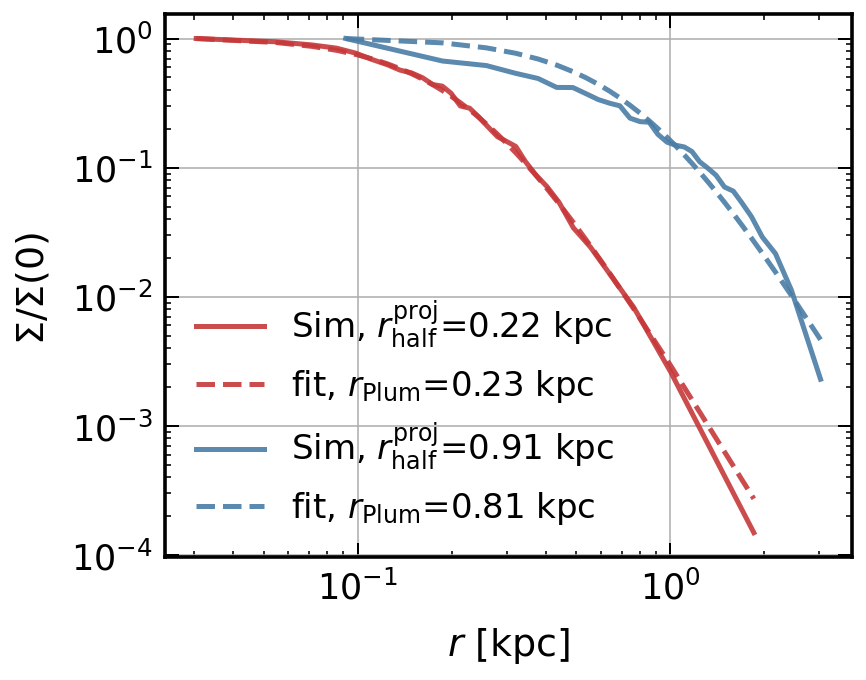

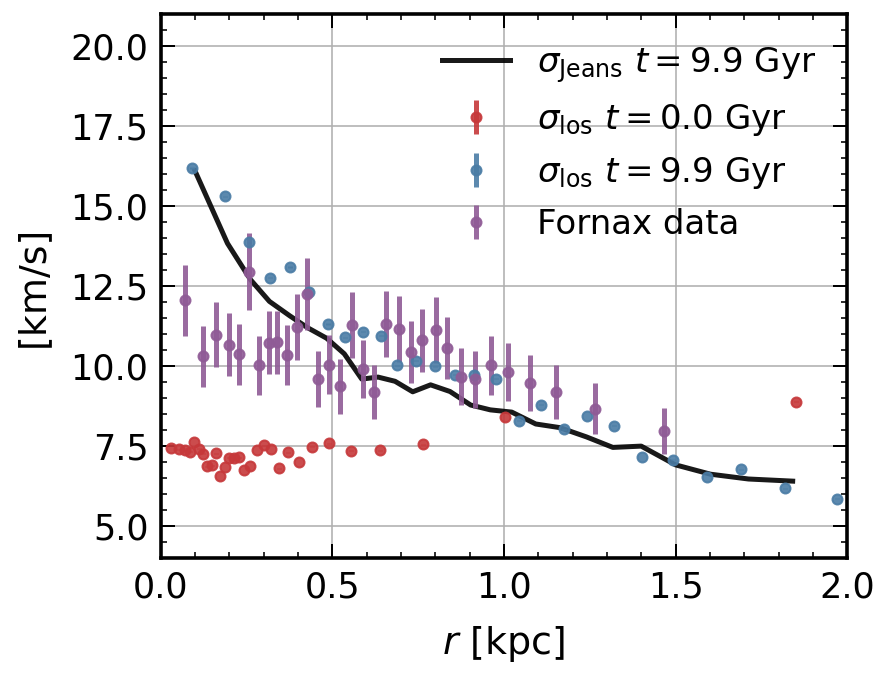

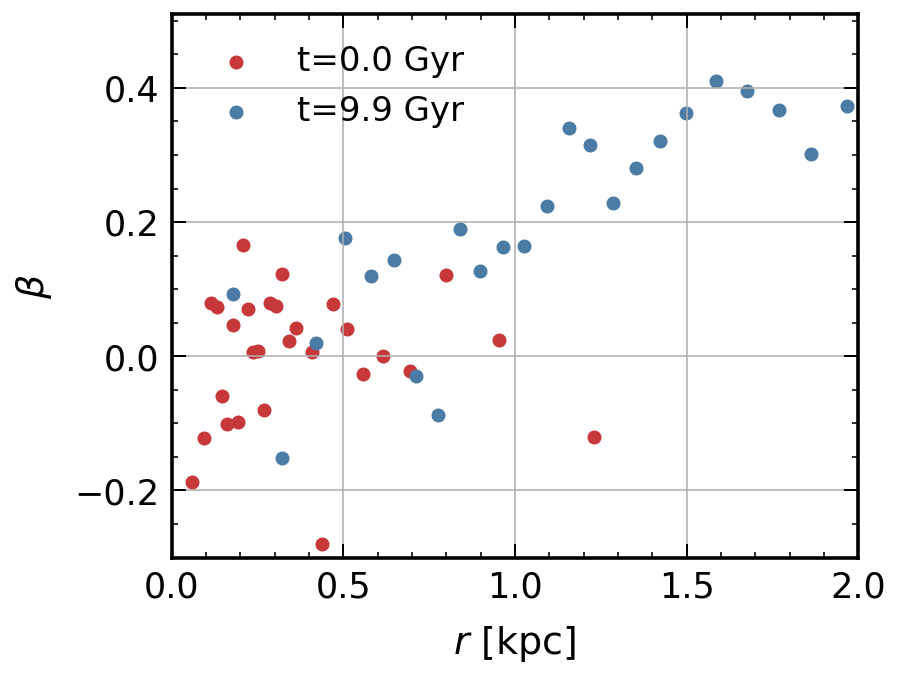

In [22]:
fig_plum, ax_plum = plt.subplots(nrows=1,ncols=1)
fig_los, ax_los = plt.subplots(nrows=1,ncols=1)
fig_beta, ax_beta = plt.subplots(nrows=1,ncols=1)
ind_snapshot=0
print(r_half_light_proj)
ax_los.plot(distances_sigma, sigma_jeans_los_plot, label=r'$\sigma_{\rm Jeans}$ $t=$'
            +str(times_sim[ind_loop]/t_unit)[:3]+' Gyr', color='black')
for ind_loop in np.linspace(index0,index_compute,num_snapshots):
  ind_loop=int(ind_loop)
  ax_los.errorbar(dist_plot_proj_list[ind_snapshot]/x_unit, number_sigma_los_list[ind_snapshot], fmt='o', 
                  yerr=[(number_sigma_los_list[ind_snapshot][ll]/(2*(counts_proj_list[ind_snapshot][ll]-1)) 
                        if counts_proj_list[ind_snapshot][ll]>1 else np.nan) for ll in 
                        range(len(number_sigma_los_list[ind_snapshot]))], 
                  label=r'$\sigma_{\rm los} \ t=$'+str(times_sim[ind_loop]/t_unit)[:3]+' Gyr'
                  , markersize=5, color=cols_default[ind_snapshot])
  # Get the next color from the color cycle
  color = colors[ind_snapshot % len(colors)]  # Cycle through colors
  ax_plum.loglog(dist_plot_proj_list[ind_snapshot]/x_unit, number_dist_proj_list[ind_snapshot]/number_dist_proj_list[ind_snapshot][0], 
                 label=#'t='+str(times_sim[ind_loop]/t_unit)[:3]
                #  +r' Gyr, $r_{\rm half}$='+str(dist_plot[rhalf_mass_index]/x_unit)[:5]+' kpc'
                 r'Sim, $r_{\rm half}^{\rm proj}$='+str(r_half_light_proj[ind_snapshot])[:4]+' kpc',
                 color=cols_default[ind_snapshot])              
  ax_plum.loglog(dist_plot_proj_list[ind_snapshot]/x_unit,
                 plummer_column_density(dist_plot_proj_list[ind_snapshot],*np.array(params_plum[ind_snapshot]))
                 /plummer_column_density(dist_plot_proj_list[ind_snapshot][0],*np.array(params_plum[ind_snapshot])), 
            linestyle='--', color=cols_default[ind_snapshot],
            label='fit, '+#r't='+str(times_sim[ind_loop]/t_unit)[:3]+r' Gyr, '+
            r'$r_{\rm Plum}$='+str(np.abs(params_plum[ind_snapshot][0])/x_unit)[:4]+' kpc')
  # ax_beta.errorbar(dist_plot_list[ind_snapshot]/x_unit/r_half_light_proj[ind_snapshot], beta[ind_snapshot], fmt='o', 
  #                  yerr=err_beta[ind_snapshot], label='beta t='+str(times_sim[ind_loop]/t_unit)[:3]+' Gyr')
  ax_beta.scatter(dist_plot_list[ind_snapshot]/x_unit, beta[ind_snapshot],  
                   label='t='+str(times_sim[ind_loop]/t_unit)[:3]+' Gyr')
  ind_snapshot+=1
# Plot sigma_los

if "ornax" in savefig_name:
  ax_los.errorbar(bin_centers_fornax, velocity_dispersions_fornax, yerr=velocity_dispersions_err_fornax, 
             fmt='o', label='Fornax data', markersize=5)
  ax_los.set_xlim(0, 2)
elif "eoII" in savefig_name:
  ax_los.errorbar(bin_centers_leo2/1e3, velocity_dispersions_leo2, yerr=velocity_dispersions_err_leo2, fmt='o', label='Leo II data')
  ax_los.set_xlim(0, 0.55)
  ax_los.errorbar(bin_centers_carina, velocity_dispersions_carina, yerr=velocity_dispersions_err_carina, fmt='o', label='Carina data')
ax_los.set_xlabel(r'$r$ [kpc]')
ax_los.set_ylabel(r'[km/s]')
# ax_los.errorbar(bin_centers, velocity_dispersions, yerr=velocity_dispersions_err, fmt='o', label='Fornax data')
ax_los.grid()
if "eoII" in savefig_name:
  ax_los.set_ylim(0,17)
  ax_los.legend(bbox_to_anchor=(1.0, 1), ncols=2, columnspacing=0.,handletextpad=0.2, loc='upper right')
else:
  ax_los.set_ylim(4, 21)
  # ax_los.legend(bbox_to_anchor=(1.0, 1), ncols=2, columnspacing=0.,handletextpad=0.2, loc='upper right')
  ax_los.legend(bbox_to_anchor=(1.0, 1), loc='upper right')
if Lphys_run==40:
  ax_los.set_ylim(0, 24)

ax_plum.legend()
ax_plum.set_xlabel(r'$r$ [kpc]')
ax_plum.set_ylabel(r'$\Sigma/\Sigma(0)$ ')
ax_plum.grid()

# Plot beta
print('Beta', beta[0])
# ax_beta.legend(loc='lower left')
ax_beta.legend()
ax_beta.set_xlim(0,2)
ax_beta.set_xlabel(r'$r$ [kpc]')
ax_beta.set_ylabel(r'$\beta$')
ax_beta.set_ylim(bottom=-0.3)
ax_beta.grid()


## Compute half light radius as a function of time

In [23]:
rarr_half = []
for i in range(len(times_sim)):
  rarr_half.append(r_half_light(i))
rarr_half = np.array(rarr_half)

Number of stars considered at time 0.0 9999 r_half 0.2386050168123637
Number of stars considered at time 0.20496843743987828 9981 r_half 0.24049327066725792
Number of stars considered at time 0.38073935949069015 9953 r_half 0.28463853580097476
Number of stars considered at time 0.5565102815415021 9947 r_half 0.3257542633898678
Number of stars considered at time 0.7322812035923139 9945 r_half 0.3437285697908353
Number of stars considered at time 0.9080521990002152 9943 r_half 0.37647240245052
Number of stars considered at time 1.083823121051027 9940 r_half 0.4005293458920718
Number of stars considered at time 1.2595940431018389 9934 r_half 0.4325563740137141
Number of stars considered at time 1.4353649651526508 9930 r_half 0.4684610572716829
Number of stars considered at time 1.6111358872034627 9928 r_half 0.5134903288006655
Number of stars considered at time 1.8178422274496953 9921 r_half 0.5108489475936543
Number of stars considered at time 2.076436237782402 9918 r_half 0.543187927575

## Compute soliton core radius as a function of time

In [25]:
rc_arr = []
start_index_rc_arr = 1
for i in range(start_index_rc_arr,len(times_sim)):
  r_c_guess = r_c_max_density(max_density[i])
  cut_index = np.maximum(int(r_c_guess/delta_x)*4,3)
  params_sol, params_cov_sol = curve_fit(soliton_fit, distance(0,0)[:cut_index], density(i,0)[:cut_index], bounds=(0.1*r_c_guess, 8*r_c_guess))
  rc_arr.append(params_sol)
rc_arr = np.array(rc_arr)
print("rcore expected", rcore_phys_actual_expected)


rcore expected 0.08691959824500056


## Plot of half light radius

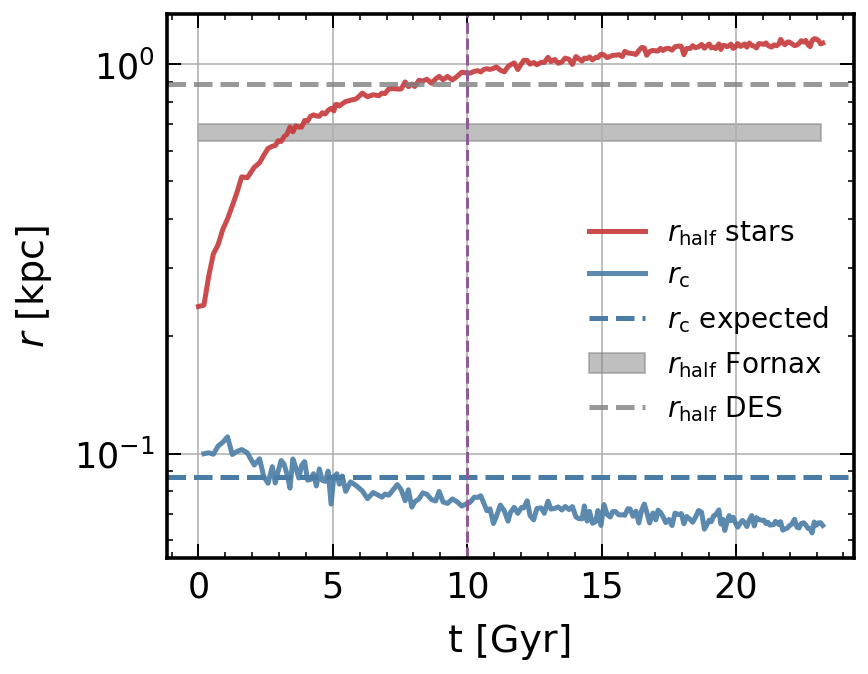

In [ ]:
rhalf_fornax = 0.668  # Example value for rplum Fornax
rhalf_fornax_err = 0.034  # Example value for the error
rhalf_fornax_des = 0.89

rhalf_leoII = 0.21
rhalf_leoII_err = 0.02
rhalf_carina = 0.24 # phys units
rhalf_carina_err = 0.02
index_start = 20

flag_other_sim = False
index_cut_time = -1
if flag_other_sim == True:
  # Load data from other simulation
  name_other_sim = 'times_sim_rhalf_Fornax_1em21_smallrPlum.csv'
  data = np.genfromtxt(name_other_sim, delimiter=',')
  times_sim_other = data[:,0]
  rarr_half_other = data[:,1]
  # Now for rc
  name_other_sim = 'times_sim_rc_arr_Fornax_1em21_smallrPlum.csv'
  data = np.genfromtxt(name_other_sim, delimiter=',')
  rc_other = data[:,1]
  index_cut_time= find_value(times_sim_other[-1], times_sim/t_unit)
  plt.plot(times_sim_other, rarr_half_other, label=r'$r_{\rm half}$ stars')
  plt.plot(times_sim_other[1:], rc_other/x_unit, label=r'$r_{\rm c}$')
  plt.plot(times_sim[:index_cut_time]/t_unit, rarr_half[:index_cut_time,0], color='red', linestyle='dotted')
  
  # plt.plot(times_sim_other, rarr_half_other, label=r'$r_{\rm half}$ other simulation')
  plt.axhline(rcore_phys_actual_expected, label=r'$r_{\rm c}$ expected', color='black')

# Add error band for rhalf Fornax
else:
  plt.plot(times_sim/t_unit, rarr_half[:,0], label=r'$r_{\rm half}$ stars')
  plt.plot(times_sim[start_index_rc_arr:]/t_unit, rc_arr/x_unit, label=r'$r_{\rm c}$')
  plt.axhline(rcore_phys_actual_expected, label=r'$r_{\rm c}$ expected', color=cols_default[1], linestyle='dashed')

if "ornax" in savefig_name:
  plt.fill_between(times_sim[:index_cut_time] / t_unit, 
                  rhalf_fornax - rhalf_fornax_err, 
                  rhalf_fornax + rhalf_fornax_err, 
                  color='gray', alpha=0.5, label=r'$r_{\rm half}$ Fornax')
  plt.axhline(rhalf_fornax_des, label=r'$r_{\rm half}$ DES', color='gray', alpha=0.8, linestyle='dashed')
elif "eoII" in savefig_name:
  plt.fill_between(times_sim[:index_cut_time] / t_unit,
                  rhalf_carina - rhalf_carina_err,
                  rhalf_carina + rhalf_carina_err,
                  color='blue', alpha=0.3, label=r'$r_{\rm half}$ Carina')
  plt.fill_between(times_sim[:index_cut_time] / t_unit, 
                  rhalf_leoII - rhalf_leoII_err, 
                  rhalf_leoII + rhalf_leoII_err, 
                  color='gray', alpha=0.9, label=r'$r_{\rm half}$ Leo II')

plt.xlabel('t [Gyr]')
plt.ylabel(r'$r$ [kpc]')
plt.yscale('log')
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.2),fontsize=14)
plt.grid()
plt.axvline(10, color=cols_default[3], linestyle='dashed',linewidth=1.5)
if Lphys_run==40:
  plt.ylim(bottom=0.2)
plt.show()
